<a href="https://colab.research.google.com/github/Existanze54/sirius-neural-networks-2024/blob/main/Practices/03S_Convolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MedMNIST - классификация изображений клеток

В этом семинаре мы поработаем с игрушечным датасетом медицинских изображений - medmnist

In [ ]:
!pip install medmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 87 kB 3.5 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115943 sha256=bd9054c1318b3ffe0587ce7fcd4921365bc93949a6e577f46a29decaf053dd7f
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire


Пример работы с bloodmnist

In [ ]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import medmnist
from medmnist import INFO, Evaluator

In [ ]:
data_flag = 'bloodmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [ ]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

  0%|          | 0/35461855 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz


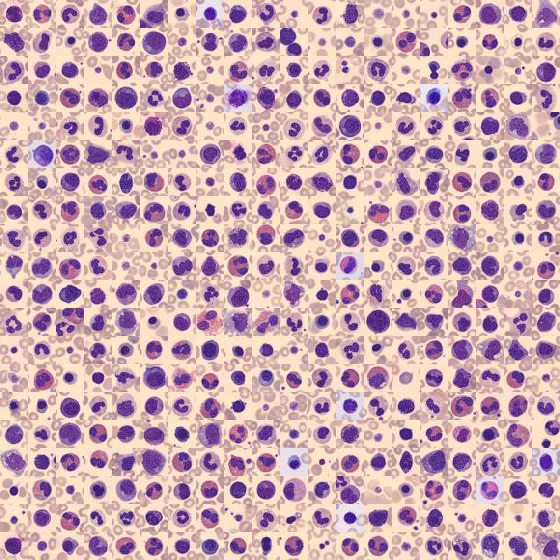

In [ ]:
train_dataset.montage(length=20)

In [ ]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset BloodMNIST (bloodmnist)
    Number of datapoints: 11959
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    License: CC BY 4.0
Datas

Небольшой пример работы сверточного слоя с 3 входными и 2 выходными каналами.

<img src="https://i.stack.imgur.com/uwHol.gif" width="800">

In [ ]:
class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        # your code here

    def forward(self, x):
        # your code here
        return x

model = Net(in_channels=n_channels, num_classes=n_classes)

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [ ]:
for epoch in range(NUM_EPOCHS):

    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze()
            loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

100%|██████████| 94/94 [00:11<00:00,  8.12it/s]


In [ ]:
def test(split):

    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])

    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().resize(-1, 1)
                outputs = outputs.softmax(dim=-1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()

        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)

        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))


print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  auc: 0.959  acc:0.760
test  auc: 0.959  acc:0.759


Проделайте действия выше на датасета RetinaMnist -- для того, чтобы понять, как его скачать, обратитесь к [документации](https://github.com/MedMNIST/MedMNIST)

Пооптимизируйте архитектуру вашей нейронной сети:

1. Поэкспериментируйте с количеством CNN-блоков

2. Попробуйте использовать GlobalAveragePooling

3. Всегда ли увеличение числа сверточных слоев в сети улучшает ее качество? Помогает ли справиться с данной проблемой BatchNorm2D?

Попробуйте применить оптимизированную архитектуру к задаче, разобранной в начале. Улучшилось ли качество и на этом датасете?